In [4]:
import os
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.scheduler_utils import create_scheduler
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [ ]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config(config_path="config/vit_bs512_ep50_lr1e-04_ds1000.yml")
cfg=get_config()
print(cfg)

[INFO] Config Path: config/vit_bs512_ep50_lr1e-04_ds1000.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
namespace(model_tag='ViT_base_augreg_in21k_ft_in1k', backbone='vit_augreg_in21k_ft_in1k', batch_size=32, epochs=50, learning_rate=0.0001, patience=12, input_shape=(1, 32, 32), global_max=121.79151153564453, dataset_root_dir='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled', train_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/file_labels_train.csv', val_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml

In [6]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau


In [7]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
# torch.backends.cudnn.benchmark = True

[INFO] Using device: cuda


In [8]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 25
[INFO] Length of validation dataloader: 3
[INFO] Length of test dataloader: 4


In [9]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using ViT model: vit_base_patch16_224.augreg_in21k_ft_in1k, pretrained: True


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='no

In [10]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
else:
    print("Using single GPU")
    

Using single GPU


In [12]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [13]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [14]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json


In [15]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [16]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [17]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    scheduler.step(val_metrics['accuracy'])  # or macro average accuracy if defined
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"📉 Current LR: {current_lr}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, current_lr, all_epoch_metrics, cfg.output_dir)
    
    # save_epoch_checkpoint(
    #     epoch=epoch,
    #     model=model,
    #     optimizer=optimizer,
    #     metrics=val_metrics,
    #     output_dir=cfg.output_dir
    # )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 1: Energy Loss =0.5747, αs Loss = 1.1066, Q0 Loss = 1.4164, Total Loss = 3.0976
📉 Current LR: 0.0001
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
✅ Best model saved at epoch 1 with total accuracy: 0.0833
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 2: Energy Loss =0.6012, αs Loss = 1.1085, Q0 Loss = 1.4087, Total Loss = 3.1184
📉 Current LR: 0.0001
[INFO] Epoch 2: Saving metrics to disk
💾 Last model saved at epoch 2
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.7500, αs Acc = 0.3646, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 3: Energy Loss =0.6120, αs Loss = 1.1348, Q0 Loss = 1.4276, Total Loss = 3.1744
📉 Current LR: 0.0001
[INFO] Epoch 3: Saving metrics to disk
💾 Last model saved at epoch 3
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3646, Q0 Acc = 0.2500, Total Acc = 0.1042
[INFO] Epoch 4: Energy Loss =0.5698, αs Loss = 1.1315, Q0 Loss = 1.4351, Total Loss = 3.1364
📉 Current LR: 0.0001
[INFO] Epoch 4: Saving metrics to disk
💾 Last model saved at epoch 4
✅ Best model saved at epoch 4 with total accuracy: 0.1042
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.4583, Q0 Acc = 0.3125, Total Acc = 0.0625
[INFO] Epoch 5: Energy Loss =0.5455, αs Loss = 1.0479, Q0 Loss = 1.4272, Total Loss = 3.0206
📉 Current LR: 0.0001
[INFO] Epoch 5: Saving metrics to disk
💾 Last model saved at epoch 5
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.4479, Q0 Acc = 0.2812, Total Acc = 0.1042
[INFO] Epoch 6: Energy Loss =0.5575, αs Loss = 1.0339, Q0 Loss = 1.4213, Total Loss = 3.0127
📉 Current LR: 0.0001
[INFO] Epoch 6: Saving metrics to disk
💾 Last model saved at epoch 6
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =0.7500, αs Acc = 0.4271, Q0 Acc = 0.2917, Total Acc = 0.0208
[INFO] Epoch 7: Energy Loss =0.5478, αs Loss = 1.0623, Q0 Loss = 1.4059, Total Loss = 3.0160
📉 Current LR: 0.0001
[INFO] Epoch 7: Saving metrics to disk
💾 Last model saved at epoch 7
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =0.7500, αs Acc = 0.4792, Q0 Acc = 0.2292, Total Acc = 0.0938
[INFO] Epoch 8: Energy Loss =0.5409, αs Loss = 1.0401, Q0 Loss = 1.3924, Total Loss = 2.9733
📉 Current LR: 0.0001
[INFO] Epoch 8: Saving metrics to disk
💾 Last model saved at epoch 8
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =0.7500, αs Acc = 0.3750, Q0 Acc = 0.2188, Total Acc = 0.0938
[INFO] Epoch 9: Energy Loss =0.5323, αs Loss = 1.0964, Q0 Loss = 1.3799, Total Loss = 3.0086
📉 Current LR: 5e-05
[INFO] Epoch 9: Saving metrics to disk
💾 Last model saved at epoch 9
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =0.7500, αs Acc = 0.4792, Q0 Acc = 0.3125, Total Acc = 0.1146
[INFO] Epoch 10: Energy Loss =0.5315, αs Loss = 1.0691, Q0 Loss = 1.3927, Total Loss = 2.9933
📉 Current LR: 5e-05
[INFO] Epoch 10: Saving metrics to disk
💾 Last model saved at epoch 10
✅ Best model saved at epoch 10 with total accuracy: 0.1146
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =0.7396, αs Acc = 0.4167, Q0 Acc = 0.3646, Total Acc = 0.0729
[INFO] Epoch 11: Energy Loss =0.5174, αs Loss = 1.0715, Q0 Loss = 1.3567, Total Loss = 2.9456
📉 Current LR: 5e-05
[INFO] Epoch 11: Saving metrics to disk
💾 Last model saved at epoch 11
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 12/50


[INFO] Epoch 12: Energy Acc =0.6771, αs Acc = 0.4271, Q0 Acc = 0.2812, Total Acc = 0.0833
[INFO] Epoch 12: Energy Loss =0.5956, αs Loss = 1.1277, Q0 Loss = 1.4601, Total Loss = 3.1834
📉 Current LR: 5e-05
[INFO] Epoch 12: Saving metrics to disk
💾 Last model saved at epoch 12
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 13/50


[INFO] Epoch 13: Energy Acc =0.7188, αs Acc = 0.4271, Q0 Acc = 0.2604, Total Acc = 0.0312
[INFO] Epoch 13: Energy Loss =0.5465, αs Loss = 1.0889, Q0 Loss = 1.4168, Total Loss = 3.0521
📉 Current LR: 5e-05
[INFO] Epoch 13: Saving metrics to disk
💾 Last model saved at epoch 13
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 14/50


[INFO] Epoch 14: Energy Acc =0.7083, αs Acc = 0.3542, Q0 Acc = 0.2396, Total Acc = 0.0729
[INFO] Epoch 14: Energy Loss =0.5865, αs Loss = 1.1516, Q0 Loss = 1.4626, Total Loss = 3.2007
📉 Current LR: 5e-05
[INFO] Epoch 14: Saving metrics to disk
💾 Last model saved at epoch 14
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 15/50


[INFO] Epoch 15: Energy Acc =0.7292, αs Acc = 0.4375, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 15: Energy Loss =0.6023, αs Loss = 1.1445, Q0 Loss = 1.5426, Total Loss = 3.2894
📉 Current LR: 2.5e-05
[INFO] Epoch 15: Saving metrics to disk
💾 Last model saved at epoch 15
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 16/50


[INFO] Epoch 16: Energy Acc =0.6979, αs Acc = 0.4688, Q0 Acc = 0.2292, Total Acc = 0.0833
[INFO] Epoch 16: Energy Loss =0.6261, αs Loss = 1.1761, Q0 Loss = 1.5825, Total Loss = 3.3846
📉 Current LR: 2.5e-05
[INFO] Epoch 16: Saving metrics to disk
💾 Last model saved at epoch 16
⏳ No improvement. Early stop counter: 6/12
[INFO] Epoch 17/50


[INFO] Epoch 17: Energy Acc =0.7292, αs Acc = 0.4062, Q0 Acc = 0.2708, Total Acc = 0.1042
[INFO] Epoch 17: Energy Loss =0.8515, αs Loss = 1.2045, Q0 Loss = 1.8319, Total Loss = 3.8879
📉 Current LR: 2.5e-05
[INFO] Epoch 17: Saving metrics to disk
💾 Last model saved at epoch 17
⏳ No improvement. Early stop counter: 7/12
[INFO] Epoch 18/50


[INFO] Epoch 18: Energy Acc =0.7396, αs Acc = 0.5000, Q0 Acc = 0.2292, Total Acc = 0.0938
[INFO] Epoch 18: Energy Loss =0.8655, αs Loss = 1.3569, Q0 Loss = 2.0562, Total Loss = 4.2786
📉 Current LR: 2.5e-05
[INFO] Epoch 18: Saving metrics to disk
💾 Last model saved at epoch 18
⏳ No improvement. Early stop counter: 8/12
[INFO] Epoch 19/50


[INFO] Epoch 19: Energy Acc =0.7708, αs Acc = 0.4375, Q0 Acc = 0.3125, Total Acc = 0.1250
[INFO] Epoch 19: Energy Loss =1.1028, αs Loss = 1.5613, Q0 Loss = 2.2813, Total Loss = 4.9454
📉 Current LR: 2.5e-05
[INFO] Epoch 19: Saving metrics to disk
💾 Last model saved at epoch 19
✅ Best model saved at epoch 19 with total accuracy: 0.1250
[INFO] Epoch 20/50


[INFO] Epoch 20: Energy Acc =0.7708, αs Acc = 0.4792, Q0 Acc = 0.1979, Total Acc = 0.0729
[INFO] Epoch 20: Energy Loss =1.0691, αs Loss = 2.1248, Q0 Loss = 2.5995, Total Loss = 5.7934
📉 Current LR: 2.5e-05
[INFO] Epoch 20: Saving metrics to disk
💾 Last model saved at epoch 20
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 21/50


[INFO] Epoch 21: Energy Acc =0.7083, αs Acc = 0.4271, Q0 Acc = 0.2083, Total Acc = 0.1146
[INFO] Epoch 21: Energy Loss =1.3786, αs Loss = 2.2738, Q0 Loss = 3.0049, Total Loss = 6.6572
📉 Current LR: 2.5e-05
[INFO] Epoch 21: Saving metrics to disk
💾 Last model saved at epoch 21
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 22/50


[INFO] Epoch 22: Energy Acc =0.7083, αs Acc = 0.4375, Q0 Acc = 0.2083, Total Acc = 0.0938
[INFO] Epoch 22: Energy Loss =1.3817, αs Loss = 2.2002, Q0 Loss = 3.2661, Total Loss = 6.8480
📉 Current LR: 2.5e-05
[INFO] Epoch 22: Saving metrics to disk
💾 Last model saved at epoch 22
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 23/50


[INFO] Epoch 23: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.1979, Total Acc = 0.0833
[INFO] Epoch 23: Energy Loss =1.3902, αs Loss = 2.2077, Q0 Loss = 3.1882, Total Loss = 6.7861
📉 Current LR: 2.5e-05
[INFO] Epoch 23: Saving metrics to disk
💾 Last model saved at epoch 23
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 24/50


[INFO] Epoch 24: Energy Acc =0.7188, αs Acc = 0.3854, Q0 Acc = 0.1771, Total Acc = 0.0312
[INFO] Epoch 24: Energy Loss =1.5202, αs Loss = 2.5536, Q0 Loss = 3.3954, Total Loss = 7.4692
📉 Current LR: 1.25e-05
[INFO] Epoch 24: Saving metrics to disk
💾 Last model saved at epoch 24
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 25/50


[INFO] Epoch 25: Energy Acc =0.7500, αs Acc = 0.3854, Q0 Acc = 0.2292, Total Acc = 0.0729
[INFO] Epoch 25: Energy Loss =1.8594, αs Loss = 3.1460, Q0 Loss = 4.6925, Total Loss = 9.6979
📉 Current LR: 1.25e-05
[INFO] Epoch 25: Saving metrics to disk
💾 Last model saved at epoch 25
⏳ No improvement. Early stop counter: 6/12
[INFO] Epoch 26/50


[INFO] Epoch 26: Energy Acc =0.7396, αs Acc = 0.4062, Q0 Acc = 0.2083, Total Acc = 0.0833
[INFO] Epoch 26: Energy Loss =1.9886, αs Loss = 3.2835, Q0 Loss = 4.9516, Total Loss = 10.2237
📉 Current LR: 1.25e-05
[INFO] Epoch 26: Saving metrics to disk
💾 Last model saved at epoch 26
⏳ No improvement. Early stop counter: 7/12
[INFO] Epoch 27/50


[INFO] Epoch 27: Energy Acc =0.7396, αs Acc = 0.4479, Q0 Acc = 0.2396, Total Acc = 0.0938
[INFO] Epoch 27: Energy Loss =1.9869, αs Loss = 3.4676, Q0 Loss = 5.1446, Total Loss = 10.5991
📉 Current LR: 1.25e-05
[INFO] Epoch 27: Saving metrics to disk
💾 Last model saved at epoch 27
⏳ No improvement. Early stop counter: 8/12
[INFO] Epoch 28/50


[INFO] Epoch 28: Energy Acc =0.7396, αs Acc = 0.3854, Q0 Acc = 0.2292, Total Acc = 0.0521
[INFO] Epoch 28: Energy Loss =2.1094, αs Loss = 3.6366, Q0 Loss = 5.6772, Total Loss = 11.4232
📉 Current LR: 1.25e-05
[INFO] Epoch 28: Saving metrics to disk
💾 Last model saved at epoch 28
⏳ No improvement. Early stop counter: 9/12
[INFO] Epoch 29/50


[INFO] Epoch 29: Energy Acc =0.7396, αs Acc = 0.4167, Q0 Acc = 0.2500, Total Acc = 0.0938
[INFO] Epoch 29: Energy Loss =2.1737, αs Loss = 4.0804, Q0 Loss = 5.8930, Total Loss = 12.1472
📉 Current LR: 6.25e-06
[INFO] Epoch 29: Saving metrics to disk
💾 Last model saved at epoch 29
⏳ No improvement. Early stop counter: 10/12
[INFO] Epoch 30/50


[INFO] Epoch 30: Energy Acc =0.7500, αs Acc = 0.3750, Q0 Acc = 0.2292, Total Acc = 0.0625
[INFO] Epoch 30: Energy Loss =2.1714, αs Loss = 4.2260, Q0 Loss = 6.1773, Total Loss = 12.5748
📉 Current LR: 6.25e-06
[INFO] Epoch 30: Saving metrics to disk
💾 Last model saved at epoch 30
⏳ No improvement. Early stop counter: 11/12
[INFO] Epoch 31/50


[INFO] Epoch 31: Energy Acc =0.7500, αs Acc = 0.3750, Q0 Acc = 0.2396, Total Acc = 0.0625
[INFO] Epoch 31: Energy Loss =2.1421, αs Loss = 4.3178, Q0 Loss = 6.0397, Total Loss = 12.4996
📉 Current LR: 6.25e-06
[INFO] Epoch 31: Saving metrics to disk
💾 Last model saved at epoch 31
⏳ No improvement. Early stop counter: 12/12
🛑 Early stopping triggered at epoch 31. Best was at epoch 19.


In [18]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/training_summary.json

🏁 Best Model @ Epoch 19
Total Accuracy: 0.1250

🔹 ENERGY Task
  Accuracy : 0.7708
  Precision: 0.7222
  Recall   : 0.5694
  F1-Score : 0.5654

🔹 ALPHA Task
  Accuracy : 0.4375
  Precision: 0.4338
  Recall   : 0.4375
  F1-Score : 0.4165

🔹 Q0 Task
  Accuracy : 0.3125
  Precision: 0.2910
  Recall   : 0.3125
  F1-Score : 0.2468


📊 Plots saved to:
 - training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.png
 - training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/loss_accuracy_plot.pdf


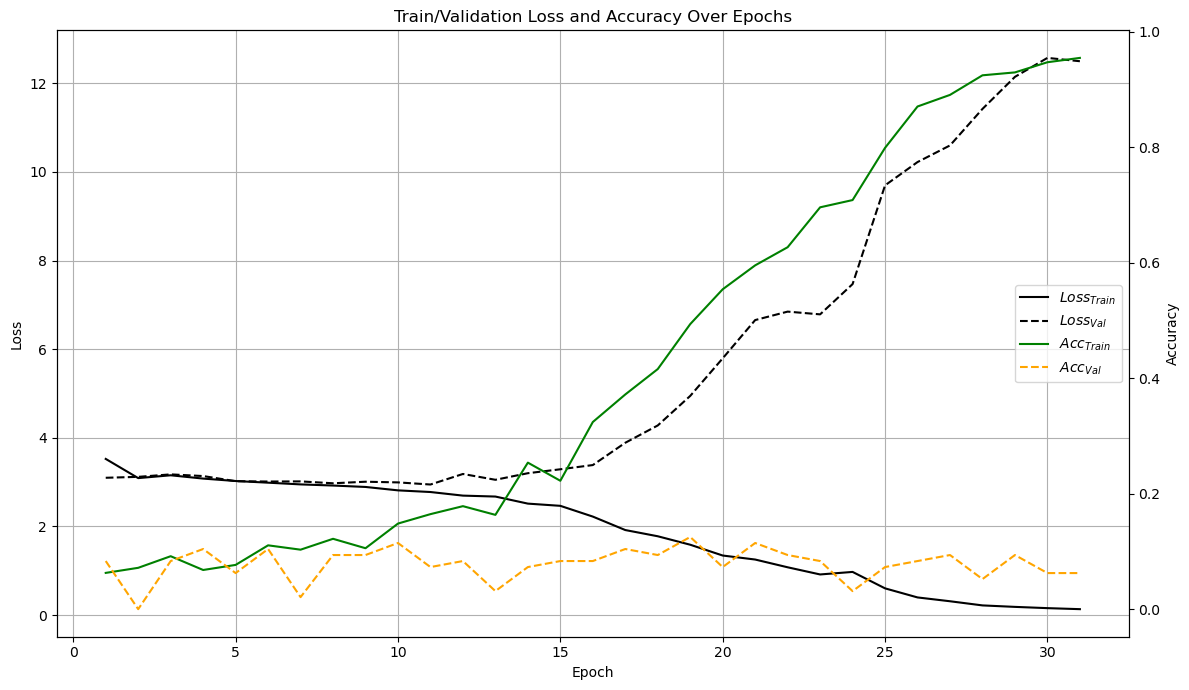

📉 Loss plot saved as:
  - training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/train_loss_and_accuracy_per_epoch_plot.pdf


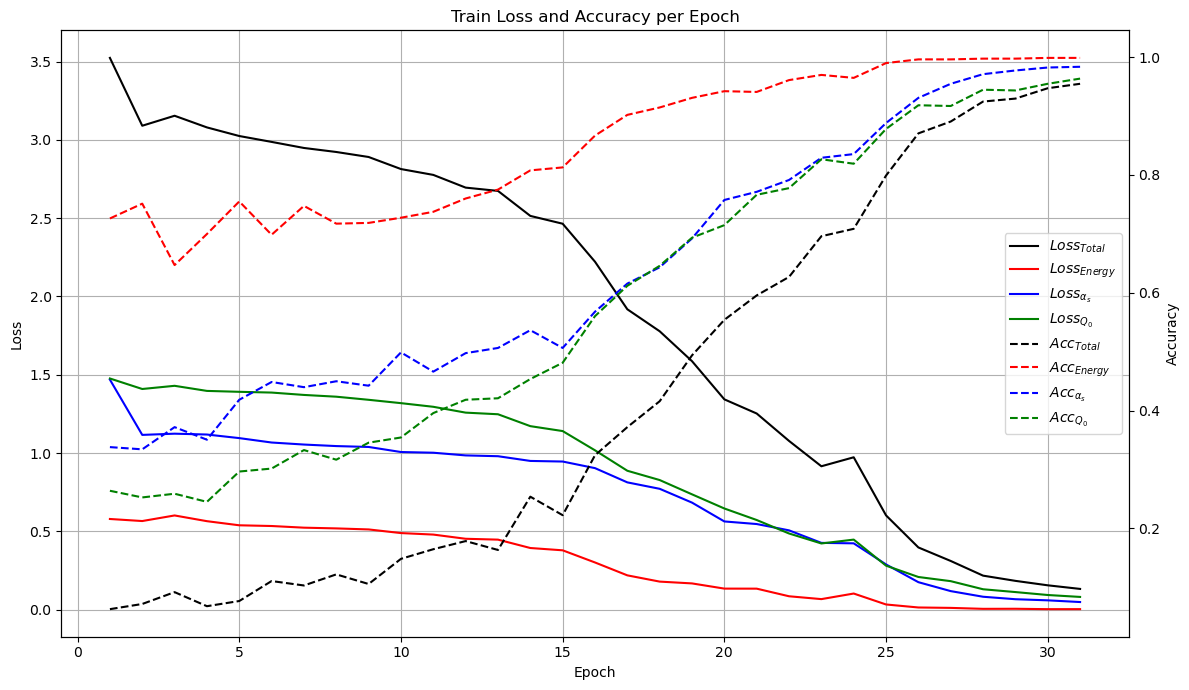

📉 Loss plot saved as:
  - training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/ViT_base_augreg_in21k_ft_in1k_bs32_ep50_lr1e-04_ds1000_g1_sched_ReduceLROnPlateau/validation_loss_and_accuracy_per_epoch_plot.pdf


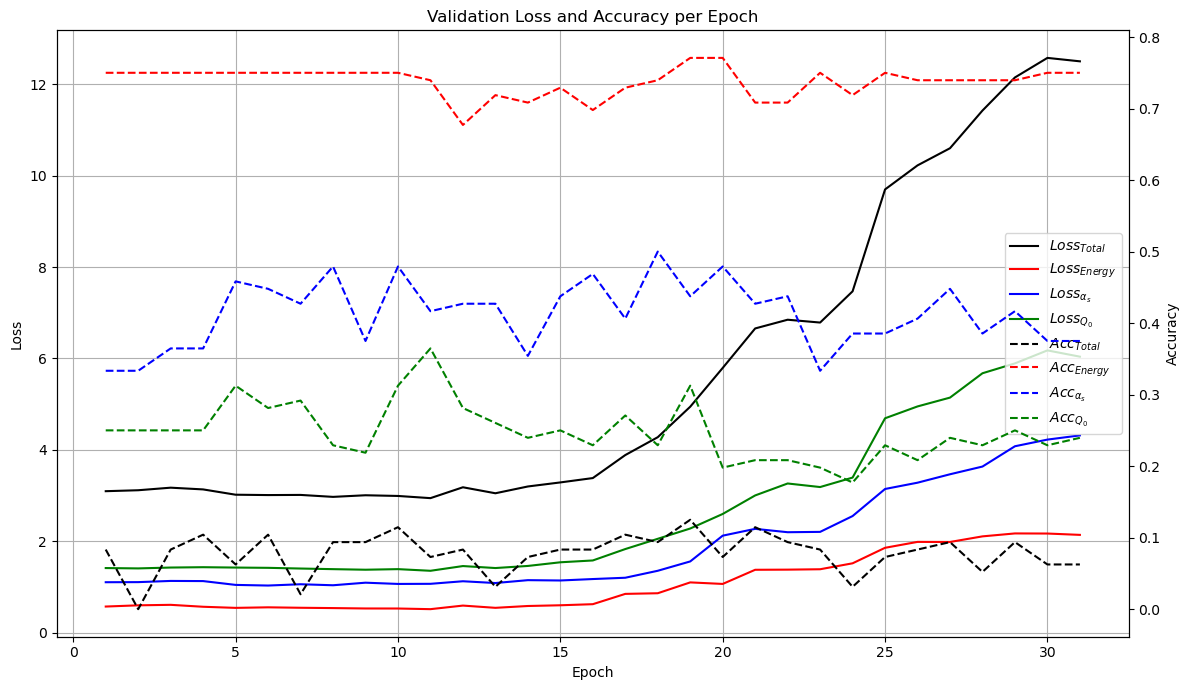

In [19]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")